In [1]:
import tensorflow as tf
from utils import util_functions as utils

In [19]:
data = utils.FashionMNISTData(resize=(28,28), batch_size=64)

In [20]:
def relu(X):
  return tf.math.maximum(X, 0)

In [23]:
class MLPScratch(utils.Classifier):
  def __init__(self, num_inputs=784, num_hiddens=256, num_outputs=10, lr=0.1, sigma=0.1):
    super().__init__(plot_train_per_epoch=1)
    self.save_hyperparameters()
    self.W1 = tf.Variable(tf.random.normal(shape=(num_inputs, num_hiddens))*sigma)
    self.b1 = tf.Variable(tf.zeros(shape=(num_hiddens)))
    self.W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, num_outputs))*sigma)
    self.b2 = tf.Variable(tf.zeros(shape=(num_outputs)))
  
  def forward(self, X):
    X = tf.reshape(X, (-1, self.num_inputs))
    H = relu(tf.matmul(X, self.W1) + self.b1)
    return tf.matmul(H, self.W2) + self.b2

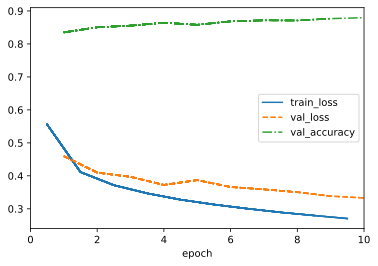

In [24]:
model = MLPScratch()
trainer = utils.Trainer(max_epochs=10)
trainer.fit(model=model, data=data)

In [6]:
model.board.data["train_loss"]

[]

In [25]:
class MLP(utils.Classifier):
  def __init__(self, num_outputs, num_hiddens, lr):
    super().__init__(plot_train_per_epoch=1)
    self.save_hyperparameters()
    self.net = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=num_hiddens, activation='relu'),
      tf.keras.layers.Dense(units=num_outputs)
    ])

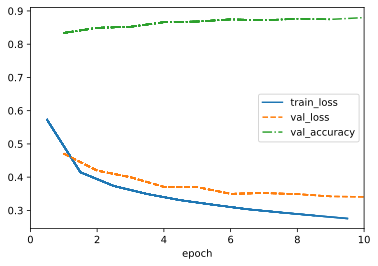

In [26]:
model = MLP(num_hiddens=256, num_outputs=10, lr=0.1)
trainer = utils.Trainer(max_epochs=10)
trainer.fit(model=model, data=data)

## Drop out Layer

In [27]:
def dropout(X, dropout):
  assert 0 <= dropout <= 1
  if dropout == 1: return tf.zeros_like(X)
  mask = tf.random.uniform(shape=tf.shape(X), minval=0, maxval=1) < 1 - dropout
  return tf.cast(mask, dtype=tf.float32) * X / 1 - dropout

In [28]:
X = tf.reshape(tf.range(16, dtype=tf.float32), (2, 8))
dropout(X, 0)

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.]], dtype=float32)>

In [29]:
dropout(X, 1)

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [30]:
dropout(X, 0.5)

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[-0.5, -0.5, -0.5, -0.5, -0.5,  4.5,  5.5,  6.5],
       [-0.5, -0.5,  9.5, -0.5, -0.5, 12.5, -0.5, -0.5]], dtype=float32)>

In [31]:
class DropoutMLPScratch(utils.Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()
    self.lin1 = tf.keras.layers.Dense(units=num_hiddens_1, activation='relu')
    self.lin2 = tf.keras.layers.Dense(units=num_hiddens_2, activation='relu')
    self.lin3 = tf.keras.layers.Dense(units=num_outputs)
  
  def forward(self, X):
    H1 = self.lin1(tf.reshape(X, (X.shape[0], -1)))
    if self.training:
      H1 = dropout(H1, self.dropout_1)
    H2 = self.lin2(H1)
    if self.training:
      H2 = dropout(H2, self.dropout_2)
    return self.lin3(H2)

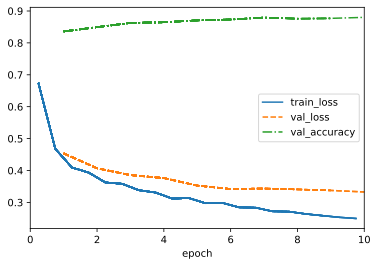

In [32]:
hparams = {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256, 'dropout_1': 0.5, 'dropout_2': 0.5, 'lr' : 0.1}
model = DropoutMLPScratch(**hparams)
trainer = utils.Trainer(max_epochs=10)
trainer.fit(model=model, data=data)

In [35]:
class DropoutMLP(utils.Classifier):
  def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, dropout_1, dropout_2, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=num_hiddens_1, activation='relu'),
      tf.keras.layers.Dropout(dropout_1),
      tf.keras.layers.Dense(units=num_hiddens_2, activation='relu'),
      tf.keras.layers.Dropout(dropout_2),
      tf.keras.layers.Dense(units=num_outputs)
    ])

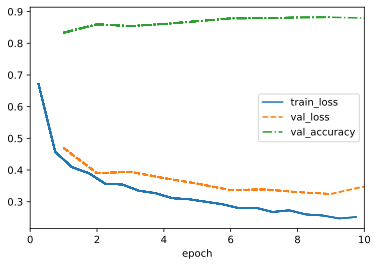

In [36]:
hparams = {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256, 'dropout_1': 0.5, 'dropout_2': 0.5, 'lr' : 0.1}
model = DropoutMLP(**hparams)
trainer = utils.Trainer(max_epochs=10)
trainer.fit(model=model, data=data)

## Housing Prices Prediction

In [2]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
from utils import util_functions as utils

In [3]:
class KaggleHouse(utils.DataModule):
  def __init__(self, batch_size, train=None, val=None):
    super().__init__()
    self.save_hyperparameters()
    if self.train is None:
      self.raw_train = pd.read_csv("datasets/train.csv")
      self.raw_val = pd.read_csv("datasets/test.csv")

  def preprocess(self):
    label = "SalePrice"
    features = pd.concat((self.raw_train.drop(columns=['Id', label]), self.raw_val['Id']))
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()/x.std()))
    features[numeric_features] = features[numeric_features].fillna(0)
    features = pd.get_dummies(features, dummy_na=True)
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

  def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    get_tensor = lambda x: tf.constant(x.values.astype(float), dtype=tf.float32)
    tensors = (get_tensor(data.drop(columns=[label])),
               tf.reshape(shape=(-1, 1), tensor=tf.math.log(get_tensor(data[label]))))
    return self.get_tensorloader(tensors, train)

In [4]:
data = KaggleHouse(batch_size=64)
data.preprocess()
print(data.train.shape)
print(data.val.shape)

(1460, 332)
(1459, 331)


In [5]:
def k_fold_data(data, k):
  rets = []
  fold_size = data.train.shape[0] // k
  for j in range(k):
    idx = range(j * fold_size, (j+1)* fold_size)
    rets.append(KaggleHouse(data.batch_size, train=data.train.drop(index=idx), val=data.train.loc[idx]))

  return rets

In [9]:
class LinearRegression(utils.Module):
  """Linear Regression implemented with high level API"""
  def __init__(self, lr):
    super().__init__()
    self.save_hyperparameters()
    initializer = tf.random_normal_initializer(stddev=0.01)
    self.net = tf.keras.layers.Dense(units=1, kernel_initializer=initializer)

  def forward(self, X):
    return self.net(X)
  
  def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

In [14]:
def k_fold(trainer, data, k, lr):
  val_loss, models = [], []
  for i, data_fold in enumerate(k_fold_data(data, k=k)):
    model = LinearRegression(lr)
    trainer.fit(model, data_fold)
    val_loss.append(float(model.board.data['val_loss'][-1].y))
    models.append(models)
  
  return models

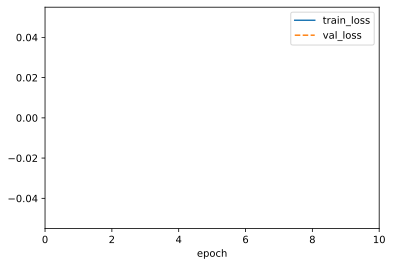

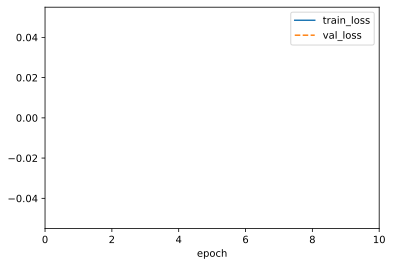

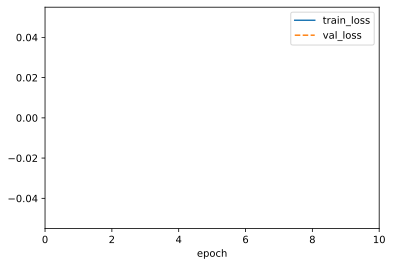

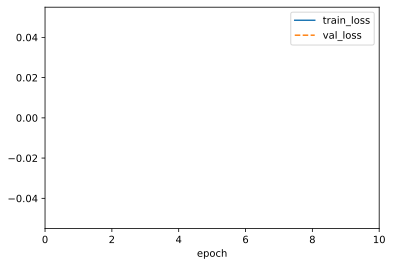

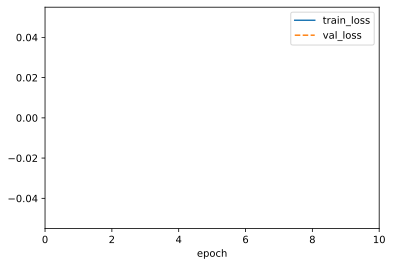

In [15]:
trainer = utils.Trainer(max_epochs=10)
models = k_fold(trainer, data, 5, 0.01)

In [5]:
label = "SalePrice"
features = pd.concat((data.raw_train.drop(columns=['Id', label]), data.raw_val['Id']))

In [6]:
features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,0
0,60.0,RL,65.0,8450.0,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,2.0,2008.0,WD,Normal,NaN
1,20.0,RL,80.0,9600.0,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,NaN,NaN,NaN,0.0,5.0,2007.0,WD,Normal,NaN
2,60.0,RL,68.0,11250.0,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,9.0,2008.0,WD,Normal,NaN
3,70.0,RL,60.0,9550.0,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,NaN,NaN,NaN,0.0,2.0,2006.0,WD,Abnorml,NaN
4,60.0,RL,84.0,14260.0,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,NaN,NaN,NaN,0.0,12.0,2008.0,WD,Normal,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2915.0
1455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2916.0
1456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2917.0
1457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2918.0


In [7]:

numeric_features

Index([   'MSSubClass',   'LotFrontage',       'LotArea',   'OverallQual',
         'OverallCond',     'YearBuilt',  'YearRemodAdd',    'MasVnrArea',
          'BsmtFinSF1',    'BsmtFinSF2',     'BsmtUnfSF',   'TotalBsmtSF',
            '1stFlrSF',      '2ndFlrSF',  'LowQualFinSF',     'GrLivArea',
        'BsmtFullBath',  'BsmtHalfBath',      'FullBath',      'HalfBath',
        'BedroomAbvGr',  'KitchenAbvGr',  'TotRmsAbvGrd',    'Fireplaces',
         'GarageYrBlt',    'GarageCars',    'GarageArea',    'WoodDeckSF',
         'OpenPorchSF', 'EnclosedPorch',     '3SsnPorch',   'ScreenPorch',
            'PoolArea',       'MiscVal',        'MoSold',        'YrSold',
                     0],
      dtype='object')

In [8]:

features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,0
0,58.654929,RL,62.115476,8448.946343,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.068668,NaN,NaN,NaN,-0.087658,-0.338311,496.198833,WD,Normal,0.000000
1,18.654929,RL,77.115476,9598.946343,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.068668,NaN,NaN,NaN,-0.087658,2.661689,495.198833,WD,Normal,0.000000
2,58.654929,RL,65.115476,11248.946343,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.068668,NaN,NaN,NaN,-0.087658,6.661689,496.198833,WD,Normal,0.000000
3,68.654929,RL,57.115476,9548.946343,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.068668,NaN,NaN,NaN,-0.087658,-0.338311,494.198833,WD,Abnorml,0.000000
4,58.654929,RL,81.115476,14258.946343,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.068668,NaN,NaN,NaN,-0.087658,9.661689,496.198833,WD,Normal,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,2909.802067
1455,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,2910.802067
1456,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,2911.802067
1457,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,2912.802067


In [ ]:
features = pd.get_dummies(features, dummy_na=True)